## Resonance weights using the HLCI method
This notebook calculates relative resonance weights of Molecules in a Species using the Huckel-Lewis Configuration Interaction method as discussed in:
D. Hagebaum-Reignier, R. Girardi, Y. Carissan, S. Humbel, J. Mol. Struc. THEOCHEM 817 (2007) 99-109, doi: 10.1016/j.theochem.2007.04.026

This code is currently not implemented in the RMG software, and is made available in this notebook.

This method performs relatively well for the following species:


[ `[CH2]C=O` <-> `C=C[O]` ]


[ `[O-][N]=C` <-> `[CH2]N=O` <-> `C=N[O]` ]


[ `O=CN` <-> `[O-]C=[NH2+]` ]


But doesn't differentiate between other forms such as:


[ `[CH2]C=CC=C` <-> `C=C[CH]C=C` <-> `C=CC=C[CH2]` ]


[ `[CH]1C=CC(=O)C=C1` <-> `C1(=O)C=CC=C[CH]1` ]

The code currently does not differentiate between different resonating groups in a species, and will populate electrons in orbitals starting from the lowest energy without considering which group the electron belongs to.

In [4]:
import numpy as np
from rmgpy.species import Species
from rmgpy.molecule import Molecule
from IPython.display import display
import time

In [2]:
class HLCI(object):
    """
    A class of the Huckel-Lewis Configuration-Interaction (HL-CI) method
    
    Based on Humble 2007:
    D. Hagebaum-Reignier, R. Girardi, Y. Carissan, S. Humbel, J. Mol. Struc. THEOCHEM 817 (2007) 99-109
    doi: 10.1016/j.theochem.2007.04.026
    
    The attributes are:

    ======================== =================== ======================================================================
    Attribute                Type                Description
    ======================== =================== ======================================================================
    `species`                :class:`Species`    The species on which calculation is performed
    `number_of_structures`   ``int``             The number of Molecules in self.species
    `nonreactive_structures` ``list``            Indixes of Molecules in the Species with `.reactive = False`
    `number_of_reactive`     ``int``             The number of Molecules in the Species with `.reactive = True`
    `number_of_atoms`        ``int``             The number of atoms that participate in mesomery
    `electrons`              ``int``             The number of electrons participaring in mesomery
    `M`                      ``numpy array``     The Huckel Matrix of the resonance hybrid
    `Mi`                     ``list``            The Huckel Matrices of the localized contributors
    `eigvals`                ``list``            The eigenvalues of M
    `eigvects`               ``list``            The eigenvectors of M
    `eigvals_i`              ``list``            The eigenvalues of each matrix in Mi
    `eigvects_i`             ``list``            The eigenvectors of each matrix in Mi
    `E`                      ``list``            The total energy of the resonance hybrid as: E[0]*alpha + E[1]*beta
    `Ei`                     ``list``            The total energies of the resonance contributors as:
                                                     E[0]*alpha + E[1]*beta
    `DEi`                    ``list``            The differences `Ei-E` for all resonance contributors.
                                                     Stores only the beta coefficients.
    `B`                      ``float``           The interaction energy difference
    `mesomery_atom_ids`      ``list``            The Atom.id's of the atoms participating in the mesomery
    `consecutive_atom_ids`   ``dictionary``      Keys: mesomery_atom_ids, Values: positive consecutive indices
    `lp_rad_array`           ``list``            An array where each entry is a list corresponding to an atom and
                                                     contains [lone_pairs,radical] lists of each resonance contributor
    `occ_local_lp`           ``dictionary``      Keys: structure number, Values: list of consecutive_atom_ids
                                                     corresponding to occupied localized lone pair orbitals
    `occ_local_rads`         ``dictionary``      Keys: structure number, Values: list of consecutive_atom_ids
                                                     corresponding to occupied localized radical orbitals
    `C`                      ``list``            The solution set to the non-linear HL-CI and Coulson-Chirgwin system
    `w`                      ``list``            The weights of the resonance contributors
    ======================== =================== ======================================================================
    """
    
    def __init__(self,species):
        t0 = time.time()  # temp
        # Check that atom ids were assigned.
        # Since atom ids are `-1` by default, simply check that two ids are different
        assert species.molecule[0].atoms[0].id != species.molecule[0].atoms[1].id, "Cannot run the HL-CI method before assigning atom ids"
        self.species = species
        self.number_of_structures = len(self.species.molecule)
        self.move_nonreactive()
        
        if self.number_of_reactive >= 2:
            self.compute_huckel_energies()
            print "E:  ", self.E  # temp
            for Ei in self.Ei:
                print "Ei: ", Ei
            print "B = ", self.B
            max_de = max(self.DEi)
            max_de_indices = [indx for indx, de in enumerate(self.DEi) if de == max_de]
            i = 0
            while self.DEi[0] < max_de and i < 3:
                # The fist structure in the species isn't the most stable one (all structures have the same
                # alpha coefficient and beta is negative -- so higher beta implies lower energy, hence stability).
                # Reorder structures and recalc energies, since h, k values are determined based on the first structure,
                # and they should be representative of the species.
                self.species.molecule[:self.number_of_reactive] = [mol for _,mol in sorted(zip(self.DEi,self.species.molecule[:self.number_of_reactive]), key=lambda x: x[0], reverse=True)]
                self.compute_huckel_energies()
                print "E:  ", self.E  # temp
                for Ei in self.Ei:
                    print "Ei: ", Ei
                print "B = ", self.B
                max_de = max(self.DEi)
                max_de_indices = [indx for indx, de in enumerate(self.DEi) if de == max_de]
                i += 1
            self.compute_mesomery_weights()
            
            # temp
            for Ci in self.C:
                print "Ci: ", Ci
            
            for i, mol in enumerate(self.species.molecule):
                if i not in self.nonreactive_structures:
                    display(mol)
                    print "wi = {0:.1f}%".format(self.w[i] * 100)
                else:
                    print "non-reactive molecule:"
                    display(mol)
                
            print "time: ", time.time() - t0
        
        #for i in xrange(number_of_reactive):
        #    self.species.molecule[i].weight = self.w[i]
    
    def move_nonreactive(self):
        """
        Relocate any non-reactive molecule in Species to the end of the molecule list
        """
        nonreactive = sum([1 for mol in self.species.molecule if not mol.reactive])
        self.number_of_reactive = self.number_of_structures - nonreactive
        if nonreactive:
            i = 0
            while i < self.number_of_reactive:
                if not self.species.molecule[i].reactive:
                    self.species.molecule.append(self.species.molecule.pop(i))
                else:
                    i += 1
                if i == 100:  # should not be triggered, but just to be safe and not loop infinately
                    raise ValueError, "Cannot determine non reactive structures"
        self.nonreactive_structures = [i for i, mol in enumerate(self.species.molecule) if not mol.reactive]
    
    def compute_huckel_energies(self):
        """
        Constructs the classic Huckel determinant for the delocalized resonance hybrid (species)
        and the Configuration Interaction Huckel determinant for the localized resonance contributors (molecules)
        """
        self.find_atoms()
        self.M = np.zeros((self.number_of_atoms, self.number_of_atoms), dtype=np.float)
        self.Mi = np.zeros((self.number_of_reactive, self.number_of_atoms, self.number_of_atoms), dtype=np.float)

        # assume molecule[0] is the most respresentative resonance contributor, and determine all h, k parameters by it
        atoms_in_mol0 = {}  # keep a dictionary of atoms in mollecule[0], by which k paramekers are determined
        i = 0  # cannot use enumerate() in foir loop since we skip hydrogens
        for j, mol in enumerate(self.species.molecule):
            for i, atom in enumerate(mol.atoms):
                if atom.id in self.mesomery_atom_ids:
                    if j == 0:
                        atoms_in_mol0[atom.id] = atom
                        # calculate h coefficients only for the first molecule, as they are identical
                        h = self.determine_huckel_heteroatom_parameters('h',atom)
                        self.M[i,i] = -h
                        for jj in xrange(self.number_of_reactive):
                            self.Mi[jj,i,i] = -h
                        i += 1
                    for neighboring_atom in atom.bonds:
                        if atom.bonds[neighboring_atom].order > 1 and neighboring_atom.id in self.mesomery_atom_ids:
                            if j == 0:
                                k = self.determine_huckel_heteroatom_parameters('k',atom,neighboring_atom)
                            else:
                                k = self.determine_huckel_heteroatom_parameters('k',atoms_in_mol0[atom.id],atoms_in_mol0[neighboring_atom.id])
                            if atom.bonds[neighboring_atom].isTriple():
                                k *= 1
                            if self.M[self.consecutive_atom_ids[atom.id],
                                   self.consecutive_atom_ids[neighboring_atom.id]] <= k:
                                # make sure higher k values are not being overwritten (i.e., triple bonds aren't over-written by double bonds)
                                self.M[self.consecutive_atom_ids[atom.id],
                                       self.consecutive_atom_ids[neighboring_atom.id]] = k
                                self.M[self.consecutive_atom_ids[neighboring_atom.id],
                                       self.consecutive_atom_ids[atom.id]] = k
                            # the same 'k' value must be used througout all structures,
                            # even if an atom changes its valance.
                            self.Mi[j, self.consecutive_atom_ids[atom.id],
                                   self.consecutive_atom_ids[neighboring_atom.id]] = k
                            self.Mi[j, self.consecutive_atom_ids[neighboring_atom.id],
                                   self.consecutive_atom_ids[atom.id]] = k

        assert np.allclose(self.M, self.M.T, atol=1e-8), "Generated a non-symetric hybrid Huckel matrix for species {0}".format(species)

        print "M:\n", self.M
        # temp
        for Mi in self.Mi:
            print "Mi:\n", Mi
        
        self.generate_lp_rad_array()
        self.count_electrons()

        self.eigvals, self.eigvecs = np.linalg.eigh(self.M)
        self.populate_energy_levels(hybrid=True)  # self.E is updated

        self.eigvals_i = []
        self.eigvecs_i = []
        for mi in self.Mi:
            eigvals_i, eigvecs_i = np.linalg.eigh(mi)
            self.eigvals_i.append(eigvals_i)
            self.eigvecs_i.append(eigvecs_i)
        self.populate_energy_levels(hybrid=False)
        self.compute_energy_differences()  # calculate DEi and B


    def find_atoms(self):
        """
        Finds heavy atoms and generates a consecutive atom id list starting from 0
        to assist in addressing relevant matrix entries
        """
        self.mesomery_atom_ids = []     # the Atom.id
        self.consecutive_atom_ids = {}  # a positive integer for each Atom.id in the form of a dictionary
        for i, atom0 in enumerate(self.species.molecule[0].atoms):
            if atom0.isNonHydrogen():
                self.mesomery_atom_ids.append(atom0.id)
                self.consecutive_atom_ids[atom0.id] = i
        
        # temp
      #  print "mesomery_atom_ids: ", self.mesomery_atom_ids  
                        
        self.number_of_atoms=len(self.mesomery_atom_ids)

    def determine_huckel_heteroatom_parameters(self, param, atom, neighboring_atom=None):
        """
        Determine the heteroatoms correction parameters h (also called hA or hX) and k (also called kCA or kXY).
        In the reduced form of the secular Huckel determinant, use x+h instead of x, and k instead of 1.
        Data taken from F.A. Van-Catledge, J. Org. Chem., 1980, 45(23), 4801-4802, doi: 10.1021/jo01311a060
        Note that currently B, F, P, and hypervalance Cl aren't implemented in RMG, yet their values are given
        here for comprehensiveness.
        Function variables:
            `param`              A string directing the function which correction parameter to output: 'h', 'k', or 'hk'
            `atom`               The atom for which the h parameter is determined
            `neighboring_atom`   Optional. The neighbor for which the k parameter is determined in relation to atom
        """
        h_dic = {'C': 0.00, 'B': -0.45, 'N1': 0.51, 'N2': 1.37, 'O1': 0.97, 'O2': 2.09, 'F': 2.71,
                 'Si': 0.00, 'P1': 0.19, 'P2': 0.75, 'S1': 0.46, 'S2': 1.11, 'Cl': 1.48}
        k_dic = {
            'C':  {'C': 1.00, 'B': 0.73, 'N1':1.02, 'N2':0.89, 'O1':1.06, 'O2':0.66, 'F': 0.52, 'Si':0.75, 'P1':0.77, 'P2':0.76, 'S1':0.81, 'S2':0.69, 'Cl':0.62},
            'B':  {'B': 0.87, 'N1':0.66, 'N2':0.53, 'O1':0.60, 'O2':0.35, 'F': 0.26, 'Si':0.57, 'P1':0.53, 'P2':0.54, 'S1':0.51, 'S2':0.44, 'Cl':0.41},
            'N1': {'N1':1.09, 'N2':0.99, 'O1':1.14, 'O2':0.80, 'F' :0.65, 'Si':0.72, 'P1':0.78, 'P2':0.81, 'S1':0.83, 'S2':0.78, 'Cl':0.77},
            'N2': {'N2':0.98, 'O1':1.13, 'O2':0.89, 'F': 0.77, 'Si':0.43, 'P1':0.55, 'P2':0.64, 'S1':0.68, 'S2':0.73, 'Cl':0.80},
            'O1': {'O1':1.26, 'O2':1.02, 'F': 0.92, 'Si':0.65, 'P1':0.75, 'P2':0.82, 'S1':0.84, 'S2':0.85, 'Cl':0.88},
            'O2': {'O2':0.95, 'F': 0.94, 'Si':0.24, 'P1':0.31, 'P2':0.39, 'S1':0.43, 'S2':0.54, 'Cl':0.70},
            'F':  {'F': 1.04, 'Si':0.17, 'P1':0.21, 'P2':0.22, 'S1':0.28, 'S2':0.32, 'Cl':0.51},
            'Si': {'Si':0.64, 'P1':0.62, 'P2':0.52, 'S1':0.61, 'S2':0.40, 'Cl':0.34},
            'P1': {'P1':0.63, 'P2':0.58, 'S1':0.65, 'S2':0.48, 'Cl':0.35},
            'P2': {'P2':0.63, 'S1':0.65, 'S2':0.60, 'Cl':0.55},
            'S1': {'S1':0.68, 'S2':0.58, 'Cl':0.52},
            'S2': {'S2':0.63, 'Cl':0.59},
            'Cl': {'Cl':0.68},
        }
        if 'h' in param:
            try:
                token = self.generate_heteroatom_tokens(atom)
            except NotImplementedError: # don't use heteroatom correction for unimplemented tokens
                token = 'C'
            h = h_dic[token]
        if 'k' in param:
            assert neighboring_atom, "Cannot compute k parameter without knowing which neighboring atom was intended"
            try:
                token = self.generate_heteroatom_tokens(atom)
                neighbor_token = self.generate_heteroatom_tokens(neighboring_atom)
            except NotImplementedError: # don't use heteroatom correction for unimplemented tokens
                token = 'C'
                neighbor_token = 'C'
            try:
                k = k_dic[token][neighbor_token]
            except:
                k = k_dic[neighbor_token][token]
        if 'h' in param and 'k' in param and h and k:
            return h, k
        elif param == 'h':
            return h
        elif param == 'k':
            return k
        else:
            raise ValueError("Could not interpret the intendend Huckel heteroatom correction for input {0}".format(param))

    def generate_heteroatom_tokens(self, atom):
        """
        determine the respective atom token to be used for the h_dic and k_dic
        """
        token = None

        if atom.isCarbon() and atom.lonePairs == 0:
            token = 'C'
        elif atom.isSilicon() and atom.lonePairs == 0:
            token = 'Si'
        elif atom.isNitrogen():
            if atom.lonePairs >= 1:
                token = 'N1'
            elif atom.lonePairs == 0:
                token = 'N2'
        elif atom.isOxygen():
            if atom.lonePairs >= 2:
                token = 'O1'
            elif atom.lonePairs <= 1:
                token = 'O2'
        elif atom.isSulfur():
            if atom.lonePairs >= 2:
                token = 'S1'
            elif atom.lonePairs <= 1:
                token = 'S2'
        if not token:
            raise NotImplementedError("No Huckel correction found for atom {0}".format(atom))
        
     #   print "using token: ", token  # temp
        return token

    def generate_lp_rad_array(self):
        """
        Generate an array where each line is a list corresponding to an atom
        and contains [lone_pair,radical] lists for that atom in each resonance contributor
        """
        self.lp_rad_array = []
        for atom_id in self.mesomery_atom_ids:
            self.lp_rad_array.append([[mol.get_atom_by_id(atom_id).lonePairs,
                                       mol.get_atom_by_id(atom_id).radicalElectrons]
                                       for mol in self.species.molecule])

    def count_electrons(self):
        """
        Counts the electrons that participate in the mesomery,
        whether they are in localized multiple bonds, lone pairs or radicals.
        To avoid accounting for electrons twice, only *decreasing* lone pairs / radicals / multiple bonds
        between the first structure and all others are considered as resonating electrons.
        """
        assert self.mesomery_atom_ids, "Could not count resonating electrons before determining resonating atoms"
        if not self.lp_rad_array:
            self.generate_lp_rad_array()
        resonating_lone_pairs = []
        resonating_radicals = []
        # Count decrementing lone pairs and radicals
        for i in xrange(self.number_of_atoms):
            lp_diff = 0
            rad_diff = 0
            for structure_number in xrange(1,self.number_of_reactive):
                if self.lp_rad_array[i][0][0] > self.lp_rad_array[i][structure_number][0] + lp_diff:
                    # self.lp_rad_array[i][0][0] is interpreted as:
                    # self.lp_rad_array[atom][structure][0 for lone pairs, 1 for rads]
                    lp_diff = self.lp_rad_array[i][0][0] - self.lp_rad_array[i][structure_number][0]
                if self.lp_rad_array[i][0][1] > self.lp_rad_array[i][structure_number][1] + rad_diff:
                    rad_diff = self.lp_rad_array[i][0][1] - self.lp_rad_array[i][structure_number][1]
            resonating_lone_pairs.append(lp_diff * 2)
            resonating_radicals.append(rad_diff)
        # Count decrementing pi bonds:
        resonating_multiple_bonds = []
        explored_atoms = []  # track atom ids of explored atoms to assist in accounting for bonds only from one direction
        for atom_id in self.mesomery_atom_ids:
            bonds_in_all_structures = []
            for mol in self.species.molecule:
                bonds_in_all_structures.append(mol.getBonds(mol.get_atom_by_id(atom_id)))
            for key0 in bonds_in_all_structures[0]:  # check for decrementing multiple bonds in molecule[0] only
                if key0.id not in explored_atoms:
                    if bonds_in_all_structures[0][key0].order > 1:
                        # Found a multiple bond to an unexplored atom in molecule[0].
                        # Check whether any other structure has a lower bond order between this atom (atom_id)
                        # and its neighbor (key0 and key1 in different structures):
                        found_dec = False
                        for bonds in bonds_in_all_structures[1:]:
                            for key1 in bonds:
                                if key0.id == key1.id:
                                    if bonds_in_all_structures[0][key0].order > bonds[key1].order:
                                        resonating_multiple_bonds.append(2)
                                        found_dec = True
                                    break  # found this bond, stop searching for it
                            if found_dec:
                                break  # This bond decrements in at least one other structure, don't bother searching for more
            explored_atoms.append(atom_id)  # don't explore additional bonds to this atom when searching from different atoms
        print "lps: ", resonating_lone_pairs
        print "rads: ", resonating_radicals
        print "bonds: ", resonating_multiple_bonds
        self.electrons = sum(resonating_lone_pairs) + sum(resonating_radicals) + sum(resonating_multiple_bonds)
        
        # temp
        print "electrons: ", self.electrons

    def populate_energy_levels(self, hybrid=True):
        """
        Populate energy levels
        If hybrid is `True`, the energy levels are populated starting from the lowest one,
        and self.E is updated with the sum of the occupied energy levels.
        If hybrid is `False`, localized lone pairs are populated first,
        then continuing to populate starting from the lowest one
        and the localized energy levels, ei, are determined.
        """
        electron_pairs = int(self.electrons / 2)
        unpaired_electron = self.electrons % 2

        if hybrid:
            # This is the resonance hybrid
            # Compose and sort energy levels:
            ei_list = [[1,-x] for x in self.eigvals]  # E = alpha - x * beta
            ei_list.sort(key=lambda tup: tup[1], reverse=True)  # sort from the lowest ei to the highest (beta is negative)
            print "e_list: ", ei_list
            # Sum populated energies:
            self.E = [0,0]  # corresponding to alpha and beta coefficients
            for i in xrange(electron_pairs):
                self.E[0] += ei_list[i][0] * 2
                self.E[1] += ei_list[i][1] * 2
            if unpaired_electron:
                i += 1
                self.E[0] += ei_list[i][0]
                self.E[1] += ei_list[i][1]
        else:
            # These are the resonance contributors
            self.find_localized_electrons()
            self.Ei = []
            # Compose and sort energy levels:
            for structure_number in xrange(self.number_of_reactive):
                ei_list = [[1,-x] for x in self.eigvals_i[structure_number]]  # E = alpha - x * beta
                ei_list.sort(key=lambda tup: tup[1], reverse=True)  # sort from the lowest ei to the highest (beta is negative)
        #        for lp in self.occ_local_lp[structure_number]:
        #            root = -self.Mi[structure_number][lp][lp]  # lp points to the atom number, so get the opposit of the respective diagonal value
        #            for ei_number in xrange(len(ei_list)):
        #                if ei_list[ei_number][1] == root:
        #                    ei_list.insert(0,ei_list.pop(ei_number))  # remove the energy level corresponding to the unoccupied orbital, so it is not occupied
        #                    break
                for rad in self.occ_local_rads[structure_number]:
                    root = -self.Mi[structure_number][rad][rad]  # rad points to the atom number, so get the opposit of the respective diagonal value
                    for ei_number in xrange(len(ei_list)):
                        if ei_list[ei_number][1] == root:
                            ei_list.insert(self.electrons,ei_list.pop(ei_number))  # relocate the energy level corresponding to the occupied lone pair orbital to the top of the list, so it is occupied
                            break
                print "ei_list: ", ei_list
                # Sum populated energies for each structure:
                Ei = [0,0]  # corresponding to alpha and beta coefficients
                for i in xrange(electron_pairs):
                    Ei[0] += ei_list[i][0] * 2
                    Ei[1] += ei_list[i][1] * 2
                    print "occupying ei = ", ei_list[i][1], "with 2 electrons"
                if unpaired_electron:
                    i += 1
                    Ei[0] += ei_list[i][0]
                    Ei[1] += ei_list[i][1]
                    print "occupying ei = ", ei_list[i][1], "with 1 electron"
                self.Ei.append(Ei)
        
    def compute_energy_differences(self):
        """
        Sij are the overlap integrals, and the terms `Hij - E * Sij` are the interaction energy differences.
        All energy differences are assumed to be equal to a single value named B.
        Only the negative root B is taken.
        This computation follows Eq. (4) in (doi: 10.1016/j.theochem.2007.04.026),
        where the unicity of a negative root B is also shown.
        """
        n = self.number_of_reactive
        self.DEi = [Ei[1] - self.E[1] for Ei in self.Ei]
        
        sigma_list = []
        mul_index = 1
        for k in xrange(n+1):
            if k == 0:
                sigma = 1
            elif k == 1:
                sigma = sum(self.DEi)
            else:
                sigma = 0
                for leading_index in xrange(k, n+1):
                    product = self.DEi[leading_index - 1]
                    for following_index in xrange(k-1):
                        product *= self.DEi[following_index]
                    sigma += product
            sigma_list.append(sigma)
        polynomial = []
        for k in xrange(n+1):
            polynomial.insert(0,(-1)**(k-1) * (k-1) * sigma_list[n-k])
        roots = np.roots(polynomial)
        
        # temp
        print "B polynomial: ", polynomial
        print "B roots: ", roots
        if isinstance(roots[0], complex) and any([root.imag == 0 for root in roots]):
            roots = [root.real for root in roots if root.imag == 0]
        self.B = max(roots)  # roots are coeeficient * beta, where beta is negative. Hence, max(roots) returns the negative root.
        print "self.B: ", self.B
                
    def find_localized_electrons(self):
        """
        Finds the lone pair and radical orbitals in all resonance contibutors,
        and determine whether or not they are occupied.
        Relevant localized lone pairs \ radicals in a resonance contributor are identified as rows
        (and columns, since Mi are symmetric) with all off-diagonal elements equal to zero (i.e., orbitals
        that do not interact with other atoms).
        The respective orbitals are considered ocuppied if the atom posseses the highest number of
        lone pairs \ radicals of all resonance contributors (i.e., there are other resonance contibutors where
        this atom has less lone pairs \ radicals)
        """
        print self.lp_rad_array
        self.occ_local_lp = {}          # occupied localized lone pair orbitals
        self.occ_local_rads = {}        # occupied localized radical orbitals
        for structure_number in xrange(self.number_of_reactive):
            struc_occ_local_lp = []
            struc_occ_local_rads = []
            lone_pairs = rads = False
            for i in xrange(self.number_of_atoms):
                # Check whether this is a lone pair or a radical that participate in mesomery.
                # Need to satisfy three conditions: a row with all zero off-diagonal values (no multuple bonds to
                # this atom); not all entries in the res_lp_array are identical for this atom (the lone pair or rad
                # participate in mesomery); this entry has the maximum value (i.e., posseses the lone pair or radical)
                if all([self.Mi[structure_number][i][j] == 0 for j in xrange(self.number_of_atoms) if i != j]):
                    # Verify and determine occupancy:
                    if (self.lp_rad_array[i][structure_number][0] == max([lp_rad[0] for lp_rad in self.lp_rad_array[i]])
                            and any(lp_rad[0] != self.lp_rad_array[i][0][0] for lp_rad in self.lp_rad_array[i][1:])):
                        # self.lp_rad_array[i][structure_number][0] is interpreted as self.lp_rad_array[atom][structure_number][0 for lone pairs, 1 for rads]
                        struc_occ_local_lp.append(i)
                        lone_pairs = True
                    if (self.lp_rad_array[i][structure_number][1] == max([lp_rad[1] for lp_rad in self.lp_rad_array[i]])
                            and any(lp_rad[1] != self.lp_rad_array[i][0][1] for lp_rad in self.lp_rad_array[i][1:])):
                        # not `elif` since an atom could change both lp and rad, e.g., NO2.
                        struc_occ_local_rads.append(i)
                        rads = True
            self.occ_local_lp[structure_number] = struc_occ_local_lp
            self.occ_local_rads[structure_number] = struc_occ_local_rads
            # Check that there are enough electrons for all occupied lone pair and radical orbitals:
            assert len(struc_occ_local_lp) * 2 + len(struc_occ_local_rads) <= self.electrons, "Missmatch between"\
                    " the number of occupied lone pair ({0}) and radical ({1}) orbitals, and the overall number of"\
                    " pi electrons ({2}) in resonance structure {3}".format(
                    len(struc_occ_local_lp), len(struc_occ_local_rads), self.electrons,
                    self.species.molecule[structure_number])

    def compute_mesomery_weights(self):
        """
        Computing the mesomery weights by solving the HL-CI matrix of the type:
        | DE1  B   B  |   | C1 |   | 0 |
        |  B  DE2  B  | * | C2 | = | 0 |
        |  B   B  DE3 |   | C3 |   | 0 |
        (DEi, B are all known)
        along with the Coulson-Chirgwin equation sum(Ci^2)=1:
        C1^2 + C2^2 + C3^2 = 1
        For any aritrary size.
        Note that one of the equations in M * b = 0 is not unique in HL-CI,
        therefore we will only solve for (n-1) equations from the M * b = 0 system
        combined with the Coulson-Chirgwin equation.
        Once the Coulson-Chirgwin equation is added, the system is no longer linear, nor could it be linearized.
        We will use an initial guess of (1/n)^0.5 for all Ci's (which corresponds to equal weights).
        Eventually, the desired weights are given by: wi = Ci^2
        """
        from scipy.optimize import fsolve
        assert self.B is not None, "Cannot compute mesomery weights before the interaction energy difference B is determined"
        
        # generate an initial guess
#        C0 = [(1/(i+1))**0.5 for i in xrange(self.number_of_reactive)]
        C0 = [1 for i in xrange(self.number_of_reactive)]
        
        self.C = fsolve(self.hlci_obj_f, C0)
        
        self.w = [Ci ** 2 for Ci in self.C]
        
        self.hlci_checks()  # checks that the final result is physical
        
    def hlci_obj_f(self, C):
        """
        Constructs an objective function of non-linear equation system with (n-1) HL-CI linear equations
        and the non-linear Coulson-Chirgwin equation.
        C is the vector [C1,C2,C3,...] for which the functions in `f` are evaluated.
        """
        f = []
        for i in xrange(self.number_of_reactive - 1):
            fi = 0
            for j, c in enumerate(C):
                if i == j:
                    # this is a diagonal element, so use Ei
                    fi += self.DEi[j] * c
                else:
                    # this is an off-diagonal element, so use B
                    fi += self.B * c
            f.append(fi)
        # Add the Coulson-Chirgwin equation
        f.append(sum([Ci ** 2 for Ci in C])-1)
        return f
    
    def hlci_checks(self):
        """
        At the end of the run, check the contributor energies, and troubelshoot if necessary.
        (A.) Sometimes this method fails to describe the localozed energies, and results in a non deterministic
        behaviour. The symptom is when one (or more?) of the localized energy(ies) equals the overall energy
        (e.g., in the case of `[N]=S` and `N[N]`, where one of the Mi's is identical to M).
        In these cases, the first structure is assigned wi=100%, and the second wi=0%, regardless of Ei.
        This method fixed the non-deterministic behavious by setting the resonance contributor with the lowest
        energy as the dominant one (and sets a low weight for the others).
        (B.) If a species has too many resonance contibutors which were not filtered out usign qualitative rules
        (such as C=C[CH]CC=C[CH]CC=C[CH]CC=C[CH]CC=C[CH]CC=C[CH]CC which has 64 resonance contributors),
        B may have imaginary roots. In this case some Ci could be unphysical (negative) and the weights aren't
        calculated appropriately. In such cases, just give each resnance contributor an equal weight.
        """
        import logging
        DEi = [Ei[1] - self.E[1] for Ei in self.Ei]
        zero_de = []
        for i, de in enumerate(DEi):
            if de == 0:
                zero_de.append(i)
        if len(zero_de) > 0:
            logging.debug("Encountered {0} zero energy differences for species {1} while computing resonance weights. Setting lowest energy structures to highest weight.".format(len(zero_de),self.species))
            self.w = []
            minor_w = 0.1 / (self.number_of_reactive - len(zero_de))  # set minor structures to contribute 10% total
            major_w = 0.9 / len(zero_de)  # major structures contribute 90% total
            print "minor_w = ", minor_w
            print "major_w = ", major_w
            print "len(zero_de) = ", len(zero_de)
            print "zero_de = ", zero_de
            print "self.number_of_reactive = ", self.number_of_reactive
            for i in xrange(self.number_of_reactive):
                if i in zero_de:
                    self.w.append(major_w)
                else:
                    self.w.append(minor_w)
        elif isinstance(self.B, complex):
            logging.debug("Encountered only complex B roots for species {0} while computing resonance weights. Setting all weights to be equal.")
            self.w = [1.0/(self.number_of_reactive) for i in xrange(self.number_of_reactive)]
        elif any([c < 0 for c in self.C]):
            logging.debug("Encountered at least one negative C coefficient while computing resonance weights. Setting all weights to be equal.")
            self.w = [1.0/(self.number_of_reactive) for i in xrange(self.number_of_reactive)]
    

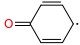

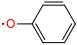

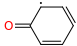

M:
[[-0.97  0.    0.    0.    1.06  0.    0.  ]
 [ 0.   -0.    1.    0.    0.    0.    1.  ]
 [ 0.    1.   -0.    1.    0.    0.    0.  ]
 [ 0.    0.    1.   -0.    0.    0.    0.  ]
 [ 1.06  0.    0.    0.   -0.    1.    0.  ]
 [ 0.    0.    0.    0.    1.   -0.    1.  ]
 [ 0.    1.    0.    0.    0.    1.   -0.  ]]
Mi:
[[-0.97  0.    0.    0.    1.06  0.    0.  ]
 [ 0.   -0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.    1.    0.    0.    0.  ]
 [ 0.    0.    1.   -0.    0.    0.    0.  ]
 [ 1.06  0.    0.    0.   -0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -0.    1.  ]
 [ 0.    0.    0.    0.    0.    1.   -0.  ]]
Mi:
[[-0.97  0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.   -0.    1.    0.    0.    0.  ]
 [ 0.    0.    1.   -0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.    1.    0.  ]
 [ 0.    0.    0.    0.    1.   -0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.   -0.  ]]
Mi:
[[-0.97  0.    0.    0.    1.06  0.  

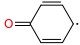

wi = 39.5%


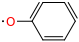

wi = 21.0%


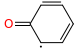

wi = 39.5%
time:  0.321131944656


In [5]:
spc0 = Species().fromSMILES('[CH]1C=CC(=O)C=C1')
spc0.generate_resonance_structures()
spc0.molecule.pop(1)
spc0.molecule.pop(1)
spc0.molecule.pop(-1)
for mol in spc0.molecule:
    display(mol)
HLCI(spc0)

In [ ]:
#spc0 = Species().fromSMILES('c1c([O])cccc1')
spc0 = Species()
spc0.molecule.append(Molecule(SMILES='c1c([O])cccc1'))
spc0.molecule.append(Molecule(SMILES='C1=C[CH]C(=O)C=C1'))
spc0.molecule.append(Molecule(SMILES='C1=C[CH]C(=O)C=C1'))
spc0.molecule.append(Molecule(SMILES='[CH]1C=CC(=O)C=C1'))

for mol in spc0.molecule:
    display(mol)
HLCI(spc0)

In [ ]:
spc0 = Species().fromSMILES('C=CC=C[CH2]')
spc0.generate_resonance_structures()
for mol in spc0.molecule:
    display(mol)
HLCI(spc0)

In [3]:
spc1 = Species()
mol1 = Molecule(SMILES='O=CN')
for atom in mol1.atoms:
    if atom.isCarbon():
        atom.id = 10
    if atom.isOxygen():
        atom.id = 20
    if atom.isNitrogen():
        atom.id = 30
mol2 = Molecule(SMILES='[O-]C=[NH2+]')
for atom in mol2.atoms:
    if atom.isCarbon():
        atom.id = 10
    if atom.isOxygen():
        atom.id = 20
    if atom.isNitrogen():
        atom.id = 30
spc1.molecule=[mol1,mol2]
for mol in spc1.molecule:
    display(mol)
HLCI(spc1)

AttributeError: 'rmgpy.molecule.molecule.Molecule' object has no attribute 'reactive'

In [ ]:
spc0 = Species().fromSMILES('N#[N+][O-]')
spc0.generate_resonance_structures(keep_isomorphic=False)
for mol in spc0.molecule:
    display(mol)
a = HLCI(spc0)

In [ ]:
spc0 = Species().fromSMILES('[NH-][N+]#N')
spc0.generate_resonance_structures(keep_isomorphic=False)
for mol in spc0.molecule:
    display(mol)
a = HLCI(spc0)

In [ ]:
spc0 = Species().fromSMILES('C=C[CH]C=O')
spc0.generate_resonance_structures(keep_isomorphic=False)
for mol in spc0.molecule:
    display(mol)
a = HLCI(spc0)

In [ ]:
spc0 = Species().fromSMILES('[CH2]N=O')
spc0.generate_resonance_structures(keep_isomorphic=False)
for mol in spc0.molecule:
    display(mol)
a = HLCI(spc0)

In [ ]:
spc0 = Species().fromSMILES('C=[C]C(=O)O[O]')
spc0.generate_resonance_structures(keep_isomorphic=False)
for mol in spc0.molecule:
    display(mol)
a = HLCI(spc0)

In [ ]:
spc0 = Species().fromSMILES('O=[N][O]')
spc0.generate_resonance_structures(keep_isomorphic=False)
for mol in spc0.molecule:
    display(mol)
a = HLCI(spc0)

In [ ]:
spc0 = Species().fromAdjacencyList("""1 N u0 p2 c0 {2,S}
2 O u1 p2 c0 {1,S}""")
spc0.generate_resonance_structures(keep_isomorphic=False)
for mol in spc0.molecule:
    display(mol)
    print mol.reactive
a = HLCI(spc0)

In [ ]:
spc0 = Species().fromSMILES('S[O]')
spc0.generate_resonance_structures(keep_isomorphic=False)
for mol in spc0.molecule:
    display(mol)
a = HLCI(spc0)

In [ ]:
spc0 = Species().fromSMILES('OS[O]')
spc0.generate_resonance_structures()
a = HLCI(spc0)

In [ ]:
spc0 = Species().fromSMILES('OS(=O)[O]')
spc0.generate_resonance_structures()
for mol in spc0.molecule:
    display(mol)
HLCI(spc0)

In [ ]:
spc0 = Species().fromSMILES('N(=[CH])[N]')
spc0.generate_resonance_structures()
for mol in spc0.molecule:
    display(mol)
HLCI(spc0)